In [143]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [144]:
def encode_string_to_boolean(df, columns):
    for column in columns:
        df[column] = df[column].map({'Yes': 1, 'No': 0,
                                     'No phone service': 0,
                                     'No internet service': 0})
        df[column] = df[column].fillna(0).astype(np.int64)
    return df

def encode_categorical(df, categorical_columns):
    return pd.get_dummies(df, columns=categorical_columns, drop_first=True)

def scale_data(df):
    scaler = StandardScaler()
    df[df.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(df.select_dtypes(include=[np.number]))
    return df

In [145]:
def round_float64_to_int64(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    if len(float_cols) > 0:
        df[float_cols] = df[float_cols].round()
        df[float_cols] = df[float_cols].fillna(0).astype(np.int64)  # or use another value instead of 0
    return df

In [146]:
TRUE_FALSE_COLUMNS = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Churn']

CATEGORICAL_COLUMNS = ['gender', 'Partner', 'Dependents', 'PhoneService',
                       'MultipleLines', 'InternetService', 'OnlineSecurity',
                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract',
                       'PaperlessBilling', 'PaymentMethod']

DROP_COLUMNS = ['customerID', 'TotalCharges']

## Data clearing & preparation

In [174]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = df.drop(columns=DROP_COLUMNS)

In [175]:
df.head()  # Display the first few rows of the DataFrame

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes


In [176]:
df.info()  # Display information about the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [177]:
for column in df.columns:
    if df[column].nunique() < 10:
        print("Column " + column + " values " + str(df[column].unique()))
    else:
        print("Column " + column + " non-categorical") # Display unique values for each column

Column gender values ['Female' 'Male']
Column SeniorCitizen values [0 1]
Column Partner values ['Yes' 'No']
Column Dependents values ['No' 'Yes']
Column tenure non-categorical
Column PhoneService values ['No' 'Yes']
Column MultipleLines values ['No phone service' 'No' 'Yes']
Column InternetService values ['DSL' 'Fiber optic' 'No']
Column OnlineSecurity values ['No' 'Yes' 'No internet service']
Column OnlineBackup values ['Yes' 'No' 'No internet service']
Column DeviceProtection values ['No' 'Yes' 'No internet service']
Column TechSupport values ['No' 'Yes' 'No internet service']
Column StreamingTV values ['No' 'Yes' 'No internet service']
Column StreamingMovies values ['No' 'Yes' 'No internet service']
Column Contract values ['Month-to-month' 'One year' 'Two year']
Column PaperlessBilling values ['Yes' 'No']
Column PaymentMethod values ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Column MonthlyCharges non-categorical
Column Churn values ['N

In [178]:
df = round_float64_to_int64(df)  # Round float64 columns to int64

In [179]:
df['Churn'].value_counts(dropna=False)  # Check for missing values in 'TotalCharges'

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [180]:
for column in TRUE_FALSE_COLUMNS:
    print(df[column].value_counts(dropna=False))  # Check for missing values

Partner
No     3641
Yes    3402
Name: count, dtype: int64
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
PhoneService
Yes    6361
No      682
Name: count, dtype: int64
PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64
TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64
StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64
StreamingMovies
N

In [181]:
df.columns  # List all columns in the DataFrame

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'Churn'],
      dtype='object')

In [182]:
df_features = encode_string_to_boolean(df, TRUE_FALSE_COLUMNS)

In [183]:
df_features.head()  # Display the first few rows of the DataFrame after encoding

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,30,0
1,Male,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,57,0
2,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,54,1
3,Male,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42,0
4,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,71,1


In [184]:
df_features = encode_categorical(df_features, CATEGORICAL_COLUMNS)

In [185]:
bool_cols = df_features.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    df_features[bool_cols] = df_features[bool_cols].astype(np.int64)  # or use another value instead of 0

In [186]:
y = df_features['Churn']
X = df_features.drop(columns=['Churn'])
X = scale_data(X)  # Scale the features

In [187]:
X.info()  # Display information about the DataFrame, including data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   float64
 1   tenure                                 7043 non-null   float64
 2   MonthlyCharges                         7043 non-null   float64
 3   gender_Male                            7043 non-null   float64
 4   Partner_1                              7043 non-null   float64
 5   Dependents_1                           7043 non-null   float64
 6   PhoneService_1                         7043 non-null   float64
 7   MultipleLines_1                        7043 non-null   float64
 8   InternetService_Fiber optic            7043 non-null   float64
 9   InternetService_No                     7043 non-null   float64
 10  OnlineSecurity_1                       7043 non-null   float64
 11  Onli

In [188]:
X.describe()  # Get a summary of the DataFrame, including statistics for numerical columns

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_1,Dependents_1,PhoneService_1,MultipleLines_1,InternetService_Fiber optic,InternetService_No,...,DeviceProtection_1,TechSupport_1,StreamingTV_1,StreamingMovies_1,Contract_One year,Contract_Two year,PaperlessBilling_1,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,...,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03
mean,-4.842546e-17,-2.421273e-17,-1.276213e-16,-2.219500e-17,7.162933e-17,1.069396e-16,7.869137e-17,-1.281257e-16,-2.471716e-17,1.437631e-17,...,3.379694e-17,8.222240e-17,-3.278807e-18,3.934569e-17,-4.136341e-17,-4.439000e-17,-5.952296e-17,-1.003819e-16,3.556245e-17,2.219500e-17
std,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,...,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-4.399165e-01,-1.318165e+00,-1.553989e+00,-1.009559e+00,-9.666223e-01,-6.540119e-01,-3.054010e+00,-8.541762e-01,-8.856598e-01,-5.259274e-01,...,-7.239675e-01,-6.394386e-01,-7.901317e-01,-7.960701e-01,-5.142494e-01,-5.629751e-01,-1.205113e+00,-5.250473e-01,-7.110260e-01,-5.448069e-01
25%,-4.399165e-01,-9.516817e-01,-9.557738e-01,-1.009559e+00,-9.666223e-01,-6.540119e-01,3.274383e-01,-8.541762e-01,-8.856598e-01,-5.259274e-01,...,-7.239675e-01,-6.394386e-01,-7.901317e-01,-7.960701e-01,-5.142494e-01,-5.629751e-01,-1.205113e+00,-5.250473e-01,-7.110260e-01,-5.448069e-01
50%,-4.399165e-01,-1.372744e-01,1.741880e-01,9.905318e-01,-9.666223e-01,-6.540119e-01,3.274383e-01,-8.541762e-01,-8.856598e-01,-5.259274e-01,...,-7.239675e-01,-6.394386e-01,-7.901317e-01,-7.960701e-01,-5.142494e-01,-5.629751e-01,8.297975e-01,-5.250473e-01,-7.110260e-01,-5.448069e-01
75%,-4.399165e-01,9.214551e-01,8.388714e-01,9.905318e-01,1.034530e+00,1.529024e+00,3.274383e-01,1.170719e+00,1.129102e+00,-5.259274e-01,...,1.381277e+00,1.563872e+00,1.265612e+00,1.256171e+00,-5.142494e-01,-5.629751e-01,8.297975e-01,-5.250473e-01,1.406418e+00,-5.448069e-01
max,2.273159e+00,1.613701e+00,1.802662e+00,9.905318e-01,1.034530e+00,1.529024e+00,3.274383e-01,1.170719e+00,1.129102e+00,1.901403e+00,...,1.381277e+00,1.563872e+00,1.265612e+00,1.256171e+00,1.944582e+00,1.776278e+00,8.297975e-01,1.904590e+00,1.406418e+00,1.835513e+00


In [189]:
X.columns.to_list()  # List all columns in the DataFrame

['SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'gender_Male',
 'Partner_1',
 'Dependents_1',
 'PhoneService_1',
 'MultipleLines_1',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_1',
 'OnlineBackup_1',
 'DeviceProtection_1',
 'TechSupport_1',
 'StreamingTV_1',
 'StreamingMovies_1',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_1',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [190]:
y.describe()  # Get a summary of the target variable

count    7043.000000
mean        0.265370
std         0.441561
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Churn, dtype: float64

## Linear regression

In [191]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [192]:
# Try different alpha values and compare the results
for alpha in [0.01, 0.05, 0.1, 0.5, 1.0]:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    y_pred = lasso_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f'Alpha: {alpha}, R-squared score: {r2}, Coefficients: {lasso_model.coef_}')

Alpha: 0.01, R-squared score: 0.29932094662541364, Coefficients: [ 0.01064702 -0.10387412  0.         -0.         -0.         -0.00465238
 -0.00333142  0.0040948   0.06758533 -0.04563605 -0.02642679 -0.00659885
 -0.         -0.02107953  0.00303758  0.01200824 -0.03606633 -0.02679085
  0.01973113 -0.          0.03955845 -0.        ]
Alpha: 0.05, R-squared score: 0.23628908316331343, Coefficients: [ 0.         -0.09606842  0.         -0.         -0.         -0.
 -0.          0.          0.06775907 -0.01070829 -0.         -0.
 -0.         -0.          0.          0.         -0.         -0.00310645
  0.00163299 -0.          0.03506689 -0.        ]
Alpha: 0.1, R-squared score: 0.12993337214588896, Coefficients: [ 0.         -0.05075077  0.         -0.         -0.         -0.
 -0.          0.          0.03093585 -0.         -0.         -0.
 -0.         -0.          0.          0.         -0.         -0.
  0.         -0.          0.01042954 -0.        ]
Alpha: 0.5, R-squared score: -3.3205599

In [193]:
# Initialize the LASSO model with alpha (regularization parameter)
lasso_model = Lasso(alpha=0.03)

# Train the model on the training data
lasso_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lasso_model.predict(X_test)

# Evaluate the model's performance using R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared score: {r2}')

R-squared score: 0.2722891002820478


In [194]:
# Display the coefficients of the features
print(f'LASSO Coefficients: {lasso_model.coef_}')

LASSO Coefficients: [ 0.00096037 -0.10024413  0.         -0.         -0.         -0.
 -0.          0.          0.07152149 -0.02451335 -0.00923992 -0.
 -0.         -0.00247966  0.          0.         -0.0194208  -0.01777281
  0.01172559 -0.          0.03944748 -0.        ]


In [195]:
# Get non-zero coefficient indices
nonzero_coef_indices = np.where(lasso_model.coef_ != 0)[0]
nonzero_features = X_train.columns[nonzero_coef_indices]

# Filter X_train and X_test to keep only nonzero features (columns)
X_train_reduced = X_train.loc[:, nonzero_features]
X_test_reduced = X_test.loc[:, nonzero_features]

# Now you can retrain your model using only the selected features
# Example: retrain LASSO or use another model
# lasso_model.fit(X_train_reduced, y_train)

In [196]:
X_train_reduced.columns.to_list()  # List the columns of the reduced training set

['SeniorCitizen',
 'tenure',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_1',
 'TechSupport_1',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_1',
 'PaymentMethod_Electronic check']

In [197]:
# Initialize the Logistic Regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train_reduced, y_train)

# Display the model's learned coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")

Intercept: [-1.5887341]
Coefficient: [ 0.0834966  -0.68437798  0.43125382 -0.43318327 -0.20340855 -0.13432867
 -0.25196308 -0.59165516  0.18945558  0.19901995]


In [198]:
# Make predictions on the testing set
y_pred = model.predict(X_test_reduced)

# Display the predictions
print("Predicted Outcomes (Pass/Fail):", y_pred)
print("Actual Outcomes:", y_test.values)

Predicted Outcomes (Pass/Fail): [1 0 0 ... 0 0 0]
Actual Outcomes: [1 0 0 ... 0 0 1]


In [199]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.8126330731014905
Confusion Matrix:
[[940  96]
 [168 205]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.55      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.81      1409



## Neural net classification

In [200]:
from sklearn.preprocessing import MinMaxScaler

X = df_features.drop(columns=['Churn'])
X = X.loc[:, nonzero_features]

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [201]:
X_scaled.shape  # Display the shape of the scaled features

(7043, 10)

In [202]:
X_scaled

array([[0.        , 0.01388889, 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.        , 0.47222222, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02777778, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.15277778, 0.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 0.05555556, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.91666667, 1.        , ..., 1.        , 1.        ,
        0.        ]])

In [203]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [204]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build the neural network model
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

/home/davy/Documents/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [205]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [206]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6666 - loss: 0.6089 - val_accuracy: 0.7977 - val_loss: 0.4391
Epoch 2/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6666 - loss: 0.6089 - val_accuracy: 0.7977 - val_loss: 0.4391
Epoch 2/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7966 - loss: 0.4372 - val_accuracy: 0.8062 - val_loss: 0.4106
Epoch 3/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7966 - loss: 0.4372 - val_accuracy: 0.8062 - val_loss: 0.4106
Epoch 3/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7881 - loss: 0.4413 - val_accuracy: 0.8098 - val_loss: 0.4053
Epoch 4/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7881 - loss: 0.4413 - val_accuracy: 0.8098 - val_loss: 0.4053
Epoch 4/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8034 - loss: 0.4166 - val_accuracy: 0.8105 - val_loss: 0.4048
Epoch 5/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8034 - loss: 0.4166 - val_accuracy: 0.

In [207]:
# Make predictions on the testing set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
# Display the predictions
print("Predicted Outcomes (Pass/Fail):", y_pred_binary.flatten())
print("Actual Outcomes:", y_test.values)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predicted Outcomes (Pass/Fail): [1 0 0 ... 0 0 0]
Actual Outcomes: [1 0 0 ... 0 0 1]
Predicted Outcomes (Pass/Fail): [1 0 0 ... 0 0 0]
Actual Outcomes: [1 0 0 ... 0 0 1]


In [208]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test, y_pred_binary)

# Display evaluation metrics
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.815471965933286
Confusion Matrix:
[[944  92]
 [168 205]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.55      0.61       373

    accuracy                           0.82      1409
   macro avg       0.77      0.73      0.75      1409
weighted avg       0.81      0.82      0.81      1409



In [209]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8183 - loss: 0.3991 
Test Accuracy: 0.8154719471931458
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8183 - loss: 0.3991 
Test Accuracy: 0.8154719471931458


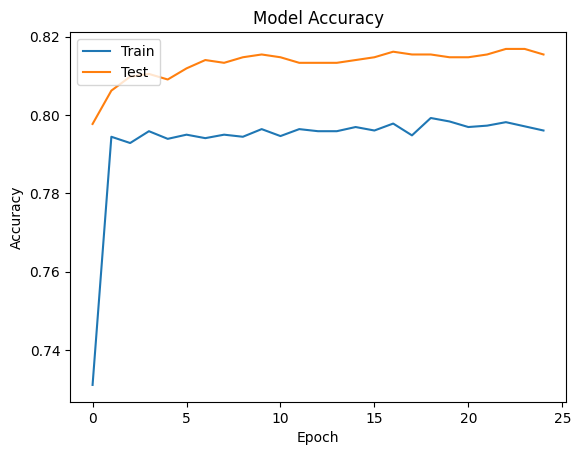

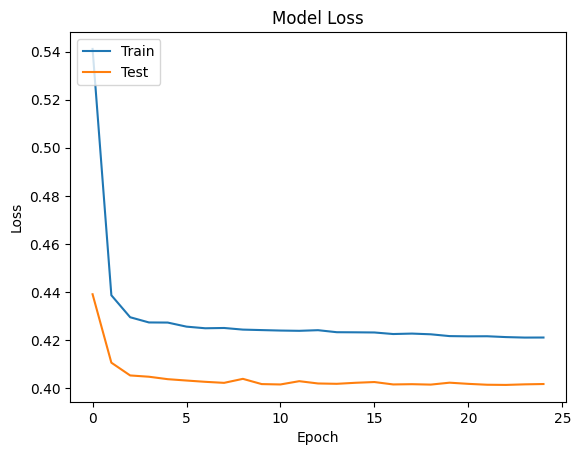

In [210]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [134]:
def predict_churn(new_data, df_features, scaler, model):
    """
    Predict churn for a new customer.
    new_data: dict or DataFrame with the same columns as the original input (before encoding/scaling)
    df_features: DataFrame after all encoding (used for column alignment)
    scaler: fitted scaler (e.g., MinMaxScaler or StandardScaler)
    model: trained model (e.g., Keras or sklearn)
    """
    # Convert to DataFrame if needed
    if isinstance(new_data, dict):
        new_df = pd.DataFrame([new_data])
    else:
        new_df = new_data.copy()

    # Encode TRUE_FALSE_COLUMNS
    TRUE_FALSE_COLUMNS = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Churn']
    for col in TRUE_FALSE_COLUMNS:
        if col in new_df.columns:
            new_df[col] = new_df[col].map({'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0}).fillna(0).astype(np.int64)

    # Encode categorical columns
    CATEGORICAL_COLUMNS = ['gender', 'Partner', 'Dependents', 'PhoneService',
                           'MultipleLines', 'InternetService', 'OnlineSecurity',
                           'OnlineBackup', 'DeviceProtection', 'TechSupport',
                           'StreamingTV', 'StreamingMovies', 'Contract',
                           'PaperlessBilling', 'PaymentMethod']
    new_df = pd.get_dummies(new_df, columns=CATEGORICAL_COLUMNS, drop_first=True)

    # Align columns with training features
    for col in df_features.drop(columns=['Churn']).columns:
        if col not in new_df.columns:
            new_df[col] = 0
    new_df = new_df[df_features.drop(columns=['Churn']).columns]

    # Scale
    new_scaled = scaler.transform(new_df)

    # Predict
    pred_prob = model.predict(new_scaled)
    pred = (pred_prob > 0.5).astype(int)
    return pred[0][0] if hasattr(pred[0], '__len__') else pred[0]

In [135]:
# Example new customer data (replace with actual values)
new_customer = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85
    # Add all other required fields as in your original dataset
}

# Predict churn (1=churn, 0=no churn)
prediction = predict_churn(new_customer, df_features, scaler, model)
print("Churn prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Churn prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Churn prediction: 0


## Data analysis

In [136]:
df_features.columns.to_list()  # List all columns in the DataFrame after encoding

['SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'Churn',
 'gender_Male',
 'Partner_1',
 'Dependents_1',
 'PhoneService_1',
 'MultipleLines_1',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_1',
 'OnlineBackup_1',
 'DeviceProtection_1',
 'TechSupport_1',
 'StreamingTV_1',
 'StreamingMovies_1',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_1',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [137]:
df_features

,SeniorCitizen,tenure,MonthlyCharges,Churn,gender_Male,Partner_1,Dependents_1,PhoneService_1,MultipleLines_1,InternetService_Fiber optic,...,DeviceProtection_1,TechSupport_1,StreamingTV_1,StreamingMovies_1,Contract_One year,Contract_Two year,PaperlessBilling_1,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,30,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,34,57,0,1,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2,0,2,54,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42,0,1,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4,0,2,71,1,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,85,0,1,1,1,1,1,0,...,1,1,1,1,1,0,1,0,0,1
7039,0,72,103,0,0,1,1,1,1,1,...,1,0,1,1,1,0,1,1,0,0
7040,0,11,30,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7041,1,4,74,1,1,1,0,1,1,1,...,0,0,0,0,0,0,1,0,0,1


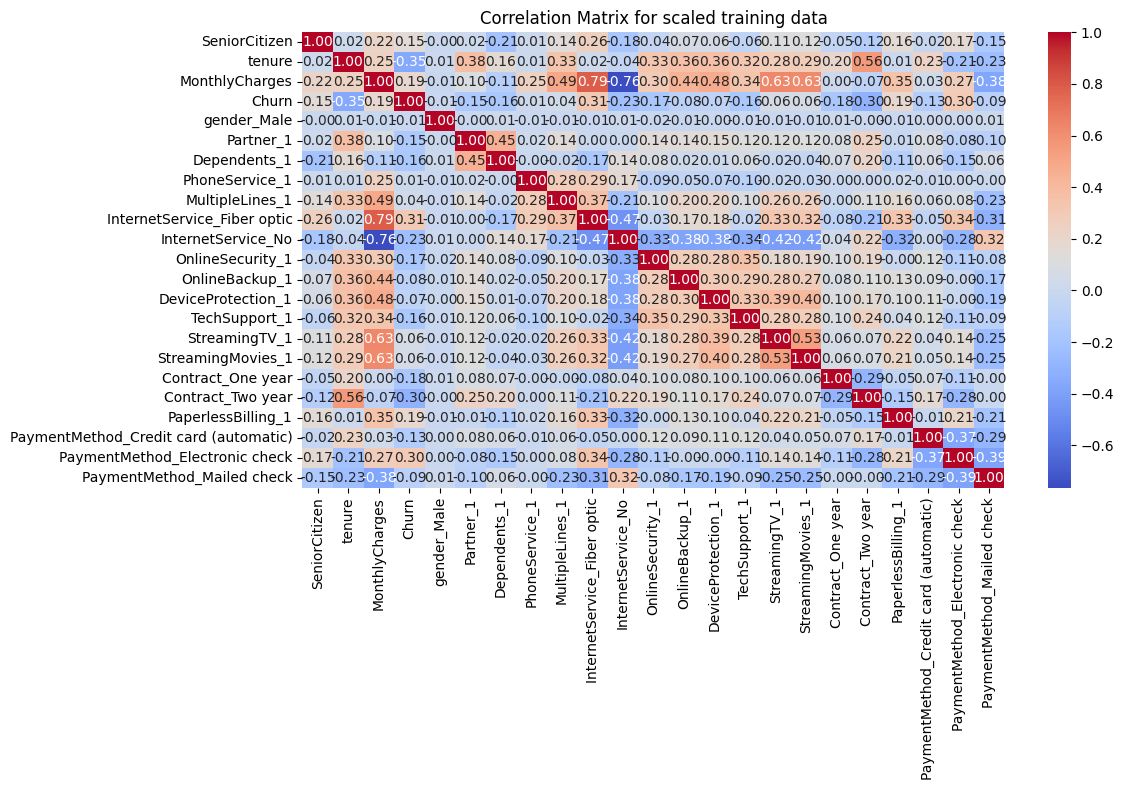

In [138]:
# Display the correlation matrix for X_train_scaled
import seaborn as sns
plt.figure(figsize=(12, 8))
corr_matrix = df_features.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for scaled training data')
plt.tight_layout()
plt.show()


Shape of X_train: (5634, 10)
Shape of X_test: (1409, 10)
Shape of y_train: (5634,)
Shape of y_test: (1409,)

Training XGBoost model...


/home/davy/Documents/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:26:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model trained.

Shape of raw predictions (probabilities): (1409,)
Sample raw predictions (y_pred_proba_xgb[:10]):
 [6.7432225e-01 2.0309262e-02 3.2323581e-04 8.5371608e-01 1.5118979e-03
 2.0099023e-01 4.3772708e-04 5.8928772e-04 1.6264163e-01 3.2848629e-01]

Shape of binary predictions: (1409,)
Sample binary predictions (y_pred_binary_xgb[:10]):
 [1 0 0 1 0 0 0 0 0 0]

Confusion Matrix (XGBoost):
 [[898 138]
 [167 206]]


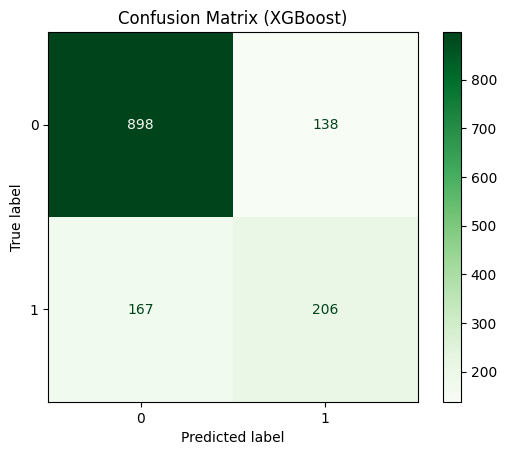


True Negatives (TN): 898 (Correctly predicted 0s)
False Positives (FP): 138 (Incorrectly predicted 1s, actual was 0)
False Negatives (FN): 167 (Incorrectly predicted 0s, actual was 1)
True Positives (TP): 206 (Correctly predicted 1s)

Calculated Accuracy (XGBoost): 0.7835
Calculated Precision (XGBoost): 0.5988
Calculated Recall (Sensitivity) (XGBoost): 0.5523
Calculated F1-Score (XGBoost): 0.5746


In [211]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

print("\nShape of X_train:", X_train_reduced.shape)
print("Shape of X_test:", X_test_reduced.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# --- 3. Initialize and Train the XGBoost Classifier ---
# For binary classification, use 'binary:logistic' objective.
# n_estimators: Number of boosting rounds (trees).
# use_label_encoder=False and eval_metric='logloss' are recommended for newer versions.
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    random_state=42,
    use_label_encoder=False, # Suppress the deprecation warning
    eval_metric='logloss' # Recommended metric for binary classification
)

print("\nTraining XGBoost model...")
xgb_model.fit(X_train_reduced, y_train)
print("XGBoost model trained.")

# --- 4. Make Predictions ---
# For binary classification, predict_proba gives probabilities, predict gives class labels.
y_pred_proba_xgb = xgb_model.predict_proba(X_test_reduced)[:, 1] # Get probabilities for the positive class (1)
y_pred_binary_xgb = xgb_model.predict(X_test_reduced) # Get the binary class labels directly

print("\nShape of raw predictions (probabilities):", y_pred_proba_xgb.shape)
print("Sample raw predictions (y_pred_proba_xgb[:10]):\n", y_pred_proba_xgb[:10])
print("\nShape of binary predictions:", y_pred_binary_xgb.shape)
print("Sample binary predictions (y_pred_binary_xgb[:10]):\n", y_pred_binary_xgb[:10])

# --- 5. Generate and Display the Confusion Matrix ---
cm_xgb = confusion_matrix(y_test, y_pred_binary_xgb)
print("\nConfusion Matrix (XGBoost):\n", cm_xgb)

# --- Visualize the Confusion Matrix ---
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0, 1])
disp_xgb.plot(cmap=plt.cm.Greens) # Using a different colormap for distinction
plt.title('Confusion Matrix (XGBoost)')
plt.show()

# --- 6. Interpret and Calculate Metrics ---
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

print(f"\nTrue Negatives (TN): {tn_xgb} (Correctly predicted 0s)")
print(f"False Positives (FP): {fp_xgb} (Incorrectly predicted 1s, actual was 0)")
print(f"False Negatives (FN): {fn_xgb} (Incorrectly predicted 0s, actual was 1)")
print(f"True Positives (TP): {tp_xgb} (Correctly predicted 1s)")

# Using sklearn's metric functions for convenience
accuracy_xgb = accuracy_score(y_test, y_pred_binary_xgb)
precision_xgb = precision_score(y_test, y_pred_binary_xgb, zero_division=0) # zero_division=0 to handle cases where precision is undefined
recall_xgb = recall_score(y_test, y_pred_binary_xgb, zero_division=0)
f1_score_xgb = f1_score(y_test, y_pred_binary_xgb, zero_division=0)

print(f"\nCalculated Accuracy (XGBoost): {accuracy_xgb:.4f}")
print(f"Calculated Precision (XGBoost): {precision_xgb:.4f}")
print(f"Calculated Recall (Sensitivity) (XGBoost): {recall_xgb:.4f}")
print(f"Calculated F1-Score (XGBoost): {f1_score_xgb:.4f}")



Shape of X_train: (5634, 10)
Shape of X_test: (1409, 10)
Shape of y_train: (5634,)
Shape of y_test: (1409,)

Training LightGBM model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
LightGBM model trained.

Shape of raw predictions (probabilities): (1409,)
Sample raw predictions (y_pred_proba_lgbm[:10]):
 [6.97374369e-01 2.48737786e-02 6.42545131e-04 8.27947546e-01
 2.80069148e-03 2.67472712e-01 2.89813404e-

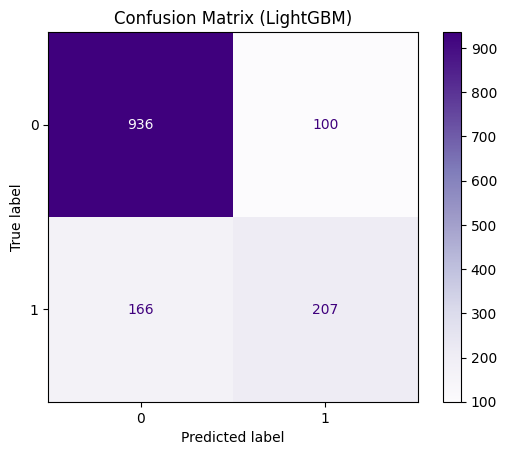


True Negatives (TN): 936 (Correctly predicted 0s)
False Positives (FP): 100 (Incorrectly predicted 1s, actual was 0)
False Negatives (FN): 166 (Incorrectly predicted 0s, actual was 1)
True Positives (TP): 207 (Correctly predicted 1s)

Calculated Accuracy (LightGBM): 0.8112
Calculated Precision (LightGBM): 0.6743
Calculated Recall (Sensitivity) (LightGBM): 0.5550
Calculated F1-Score (LightGBM): 0.6088


In [212]:
import lightgbm as lgb # Import LightGBM

# --- 2. Split Data into Training and Testing Sets ---
# It's crucial to split your data to evaluate the model's performance on unseen data.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\nShape of X_train:", X_train_reduced.shape)
print("Shape of X_test:", X_test_reduced.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# --- 3. Initialize and Train the LightGBM Classifier ---
# For binary classification, use 'binary' objective.
# n_estimators: Number of boosting rounds (trees).
lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=100,
    random_state=42,
    metric='binary_logloss' # Recommended metric for binary classification
)

print("\nTraining LightGBM model...")
lgbm_model.fit(X_train_reduced, y_train)
print("LightGBM model trained.")

# --- 4. Make Predictions ---
# For binary classification, predict_proba gives probabilities, predict gives class labels.
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_reduced)[:, 1] # Get probabilities for the positive class (1)
y_pred_binary_lgbm = lgbm_model.predict(X_test_reduced) # Get the binary class labels directly

print("\nShape of raw predictions (probabilities):", y_pred_proba_lgbm.shape)
print("Sample raw predictions (y_pred_proba_lgbm[:10]):\n", y_pred_proba_lgbm[:10])
print("\nShape of binary predictions:", y_pred_binary_lgbm.shape)
print("Sample binary predictions (y_pred_binary_lgbm[:10]):\n", y_pred_binary_lgbm[:10])

# --- 5. Generate and Display the Confusion Matrix ---
cm_lgbm = confusion_matrix(y_test, y_pred_binary_lgbm)
print("\nConfusion Matrix (LightGBM):\n", cm_lgbm)

# --- Visualize the Confusion Matrix ---
disp_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm, display_labels=[0, 1])
disp_lgbm.plot(cmap=plt.cm.Purples) # Using a different colormap for distinction
plt.title('Confusion Matrix (LightGBM)')
plt.show()

# --- 6. Interpret and Calculate Metrics ---
tn_lgbm, fp_lgbm, fn_lgbm, tp_lgbm = cm_lgbm.ravel()

print(f"\nTrue Negatives (TN): {tn_lgbm} (Correctly predicted 0s)")
print(f"False Positives (FP): {fp_lgbm} (Incorrectly predicted 1s, actual was 0)")
print(f"False Negatives (FN): {fn_lgbm} (Incorrectly predicted 0s, actual was 1)")
print(f"True Positives (TP): {tp_lgbm} (Correctly predicted 1s)")

# Using sklearn's metric functions for convenience
accuracy_lgbm = accuracy_score(y_test, y_pred_binary_lgbm)
precision_lgbm = precision_score(y_test, y_pred_binary_lgbm, zero_division=0) # zero_division=0 to handle cases where precision is undefined
recall_lgbm = recall_score(y_test, y_pred_binary_lgbm, zero_division=0)
f1_score_lgbm = f1_score(y_test, y_pred_binary_lgbm, zero_division=0)

print(f"\nCalculated Accuracy (LightGBM): {accuracy_lgbm:.4f}")
print(f"Calculated Precision (LightGBM): {precision_lgbm:.4f}")
print(f"Calculated Recall (Sensitivity) (LightGBM): {recall_lgbm:.4f}")
print(f"Calculated F1-Score (LightGBM): {f1_score_lgbm:.4f}")